# Under ice chlorophyll-a, oxygen and nitrate analysis

### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import seawater as sw
from soccom_functions import *
import pickle 
import datetime
import xarray as xr
import pandas as pd 
import plotly.graph_objs as go
import cmocean

### Read float data

For a single float

In [2]:
file_folder = "../../data/raw/WGfloats/" # specify directory relative to location of notebook
float_number = "5904397" #7900918 #9094

files = sorted(glob.glob(file_folder+"/*"+float_number+"*.nc"))
print(files)
#files = sorted(glob.glob(file_folder+"/*.nc"))

['../../data/raw/WGfloats\\5904397_HRQC.nc']


For all floats in a directory

In [ ]:
#reads float data
file_folder = "../../data/raw/WGfloats/" # specify directory relative to location of notebook

files = sorted(glob.glob(file_folder+"/*.nc"))
print(files)

### Loads and grids data from single float

In [3]:
#uses the function that reads and grids the data
FLOAT = grids_one_buoy(files[0],display_info = False, DO_ml_crit = 2.5, clear_short = True)

#the gridded data is located in the dictionary FLOAT.gr, and contains the following variables
print(FLOAT.gr.keys())
print(FLOAT.raw_bg.keys())
#some of them are standard and others related to thorpe scales and mixing, and you also have geopotential anomalies (gpa) integrated between 500 and 1500 m (gpa_500_1500)

print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))


#fmet = open("float_pickles/ERA_hr_"+FLOAT.raw["code"]+".pi","rb")
#FLOAT.methr = pickle.load( fmet )
#FLOAT.methr["time64"] = np.copy( FLOAT.methr["time"] )
#FLOAT.methr["time"] = convert_datetime64_to_time(FLOAT.methr["time64"])
#FLOAT.methr["date"] = convert_datetime64_to_date(FLOAT.methr["time64"])
#FLOAT.calculates_carbon_framework(sp = FLOAT.methr["sp"], timemet = FLOAT.methr["time"], ML_zero = False)
#CFvars = FLOAT.gr["CF"].keys()

#carbon flux
#FLOAT.calculates_CO2_O2_flux(FLOAT.methr)

C:\Users\Clara Douglas\OneDrive - University of Southampton\Phd\Projects\net_community_production\notebooks\FromBieito\soccom_functions.py:338: RuntimeWarning: Mean of empty slice
  self.gr["LT"][j,i] = np.nanmean(disp[jj]**2)**0.5


dict_keys(['depth', 'date', 'date_dt', 'Lon', 'Lat', 'code', 'WMO_code', 'Pressure', 'Temperature', 'Salinity', 'SA', 'CT', 'Sigma_theta', 'gamma_n', 'N2', 'PV', 'Oxygen', 'OxygenSat', 'Nitrate', 'DIC_LIAR', 'TALK_LIAR', 'pCO2_LIAR', 'Chl_a', 'Chl_a_corr', 'POC', 'LT', 'mld', 'mld_HT', 'mld_DO', 'LT_ml', 'LT_ov', 'LT_largest_ov', 'size_largest_ov', 'h_largest_ov', 'h_no_ov', 'gpa', 'gpa_500_1500', 'AOU'])
dict_keys(['Oxygen', 'OxygenSat', 'Nitrate', 'DIC_LIAR', 'TALK_LIAR', 'pCO2_LIAR', 'Chl_a', 'Chl_a_corr', 'POC'])
This float is WMO code: 5904397


## Initial plot of the float main variables and position

In [ ]:
%matplotlib inline 
#qt
studyarea=pd.read_csv('../../data/processed/ANDREXbox.csv',header=None).values

#with this command you can have an overview of the float data 
FLOAT.plots_map_main_variables(studyarea, shows = True, saves = False,  ylim=  (200,0))
#FLOAT.plots_mixing_layer_profile(20, show = True)

#plt.plot(FLOAT.gr["date"],FLOAT.gr["gpa_500_1500"])

## Calculate max (and mean in ML) chl in profiles

In [4]:
H = np.nanmax(FLOAT.gr["mld"]) # calculates the maximum ML
print("Deepest mixed layer: %1.0f m"%(H))

jh = np.where( FLOAT.gr["depth"]>= H)[0][0] # gets the depth index for the maxmum mixed layer ([0][0] requests the first instance - so the shallowest depth point that is greater or equal to MLD)

print(jh)
# maximum chl in water column
max_Chl_a = np.nanmax(FLOAT.gr["Chl_a"][:,:], axis = 0)
max_Chl_a_corr = np.nanmax(FLOAT.gr["Chl_a_corr"][:,:], axis = 0)
meanML_Chl_a = np.nanmean(FLOAT.gr["Chl_a_corr"][:jh,:], axis = 0)

print(np.nanmax(max_Chl_a))
print(np.nanmax(max_Chl_a_corr))

Deepest mixed layer: 142 m
29
3.4408347899872727
1.1469449299957575


In [10]:
uplim=20
deeplim=100
lowlim=150 # check what values of chl_a there are deeper than 150m - there shouldn't be any, so may indicate some drift if there is, and need to correct for that
Uh = np.where( FLOAT.gr["depth"]>= uplim)[0][0]
Dh = np.where( FLOAT.gr["depth"]>= deeplim)[0][0]
Lh = np.where( FLOAT.gr["depth"]>= lowlim)[0][0]
print(np.where( FLOAT.gr["depth"]>= lowlim)[0][0])
#
deep_Chl_a = np.nanmax(FLOAT.gr["Chl_a_corr"][Lh:,:], axis = 0)
#max_Chl_a_corr = np.nanmax(FLOAT.gr["Chl_a_corr"][Uh:Dh,:], axis = 0)
#meanML_Chl_a = np.nanmean(FLOAT.gr["Chl_a_corr"][:jh,:], axis = 0)
print(np.nanmax(deep_Chl_a))
print(np.nanmean(deep_Chl_a))


30
0.2384994489258046
0.007651439858928424


In [6]:
print(len(FLOAT.gr["date"]))

181


In [7]:
deep_Chl_a = np.where(FLOAT.gr["Chl_a_corr"][Lh:,:]>0.2)
print(deep_Chl_a)

(array([1, 2], dtype=int64), array([176, 176], dtype=int64))


In [8]:
print(FLOAT.gr["date_dt"])

[datetime.datetime(2015, 1, 22, 5, 14, 0, 4), datetime.datetime(2015, 2, 1, 16, 13), datetime.datetime(2015, 2, 12, 0, 22, 59, 999998), datetime.datetime(2015, 2, 22, 9, 33, 59, 999999), datetime.datetime(2015, 3, 4, 18, 59, 59, 999997), datetime.datetime(2015, 3, 15, 1, 54, 0, 5), datetime.datetime(2015, 3, 25, 10, 7, 0, 2), datetime.datetime(2015, 4, 4, 18, 14), datetime.datetime(2015, 4, 15, 2, 35, 59, 999995), datetime.datetime(2015, 4, 25, 11, 37, 59, 999998), datetime.datetime(2015, 5, 5, 22, 30, 59, 999996), datetime.datetime(2015, 5, 16, 8, 15, 59, 999996), datetime.datetime(2015, 5, 26, 16, 10, 0, 1), datetime.datetime(2015, 6, 5, 22, 13), datetime.datetime(2015, 6, 16, 9, 17), datetime.datetime(2015, 6, 26, 14, 57, 0, 1), datetime.datetime(2015, 7, 6, 20, 25, 0, 4), datetime.datetime(2015, 7, 17, 1, 50, 59, 999995), datetime.datetime(2015, 7, 27, 7, 27, 0, 1), datetime.datetime(2015, 8, 6, 13, 10, 59, 999998), datetime.datetime(2015, 8, 16, 18, 42, 59, 999997), datetime.datet

(array([176], dtype=int64),)


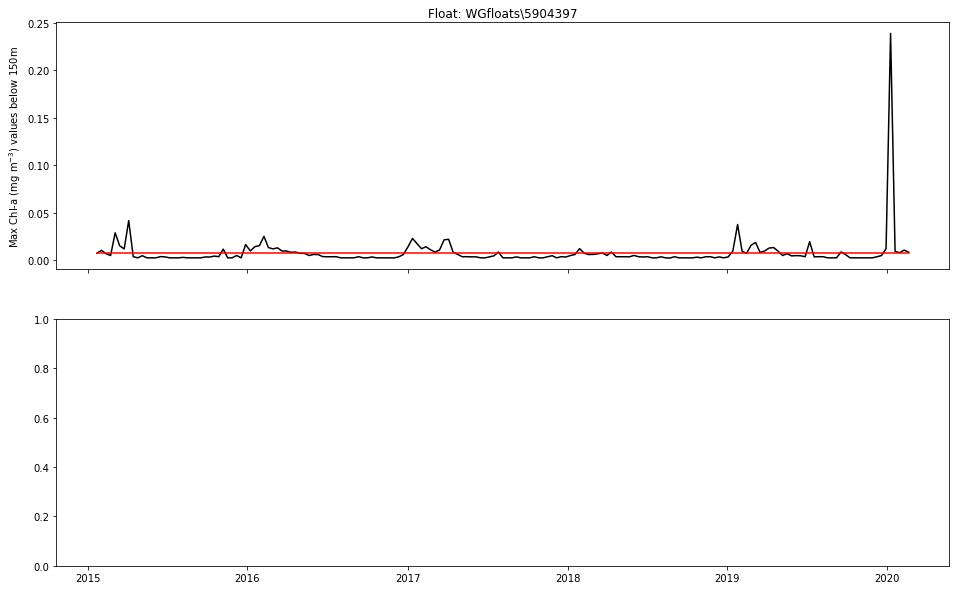

In [12]:
fig, ax = plt.subplots(2,1,figsize = (16,10), sharex = True)
ax[0].plot( FLOAT.gr["date_dt"], deep_Chl_a, "k" )
ax[0].set_ylabel( "Max Chl-a (mg m$^{-3}$) values below 150m" )
mean_deep_chl_a=[np.nanmean(deep_Chl_a)]*len(FLOAT.gr["date"])
ax[0].plot(FLOAT.gr["date_dt"], mean_deep_chl_a, "r")
ax[0].set_title("Float: %s"%(FLOAT.raw["code"]))
print(np.where(deep_Chl_a>0.2))

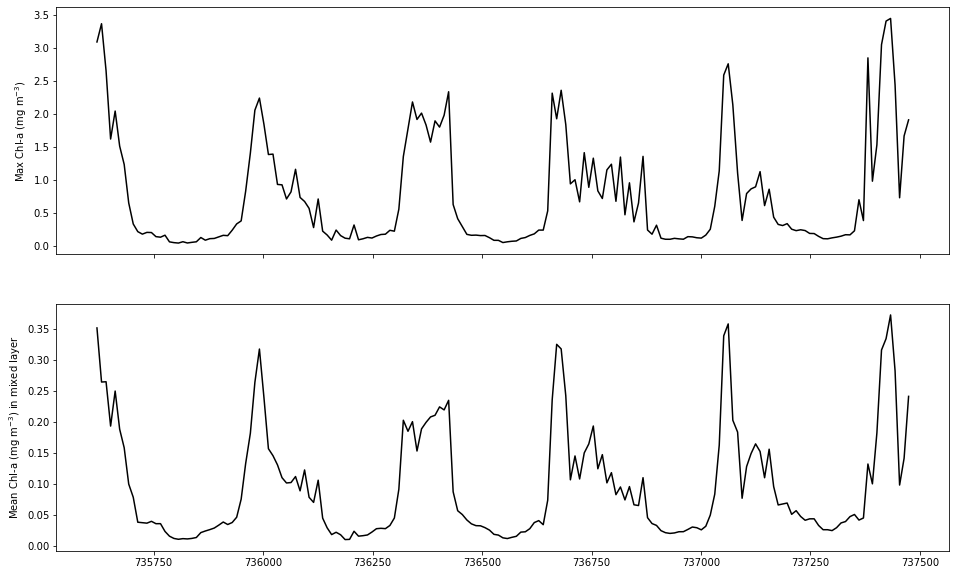

In [5]:
fig, ax = plt.subplots(2,1,figsize = (16,10), sharex = True)
ax[0].plot( FLOAT.gr["date"], max_Chl_a, "k" )
ax[0].set_ylabel( "Max Chl-a (mg m$^{-3}$)" )
ax[1].plot( FLOAT.gr["date"], meanML_Chl_a, "k" )
ax[1].set_ylabel( "Mean Chl-a (mg m$^{-3}$) in mixed layer" )
ax[1].format_xdata = mdates.DateFormatter('%Y-%m')
#ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

### Read in all floats into directory

In [ ]:
for f_ix in range(0,len(files)):
    FLOAT = grids_one_buoy(files[f_ix],display_info = False, DO_ml_crit = 2.5, clear_short = True)
    #the gridded data is located in the dictionary FLOAT.gr, and contains the following variables
    print(FLOAT.gr.keys())
    #some of them are standard and others related to thorpe scales and mixing, and you also have geopotential anomalies (gpa) integrated between 500 and 1500 m (gpa_500_1500)
    print("This float is WMO code: %s"%(FLOAT.gr["WMO_code"]))
    
    NEPt,NEP_avgt,Uyeart=calc_NEP(FLOAT)
    
    str_t=FLOAT.gr["WMO_code"]+"_NEP"
    str_av=FLOAT.gr["WMO_code"]+"_NEPav"
    
    df = pd.DataFrame(NEPt, columns = [str_t], index = [Uyeart])
    NEPdf=pd.concat([NEPdf,df],axis=1)
    dfav = pd.DataFrame(NEP_avgt, columns = [str_av], index = [Uyeart])
    NEPavdf=pd.concat([NEPavdf,dfav],axis=1)
    
    
    
    #make a map of float trajectory
    #ax0 = fig.add_axes([0.10,0.67,0.3,0.3], projection = proj) #ax0 = fig.add_axes([0.10,0.1,0.7,0.7], projection = proj)
    #ax0.gridlines(draw_labels=False)
    #ax0.set_extent([-180, 180, -90, -45], crs.PlateCarree()) # originally -25 as north extent, will shorten to -45
    #ax0.stock_img()
    #cc = ax0.scatter(FLOAT.raw["Lon"], FLOAT.raw["Lat"], 20, c = FLOAT.raw["date"],transform = crs.PlateCarree(),)#-self.raw["date"][0])
    #loc = mdates.AutoDateLocator()
    #fig.colorbar(cc, ticks=loc,format=mdates.AutoDateFormatter(loc))
    #box = ax0.plot([studyarea[:,0]],[studyarea[:,1]],transform = crs.PlateCarree(),color='green', marker=',', linestyle='dashed',linewidth=1.5, markersize=1.5)
    

       
#print(NEPdf)
#print(NEPavdf)
plt.show()
NEP_nitrate=pd.concat([NEPdf,NEPavdf],axis=1)
print(NEP_nitrate)